Directory weather_data has been deleted.
weather_data\Jansonhaugen_Res_data.dat
Jansonhaugen


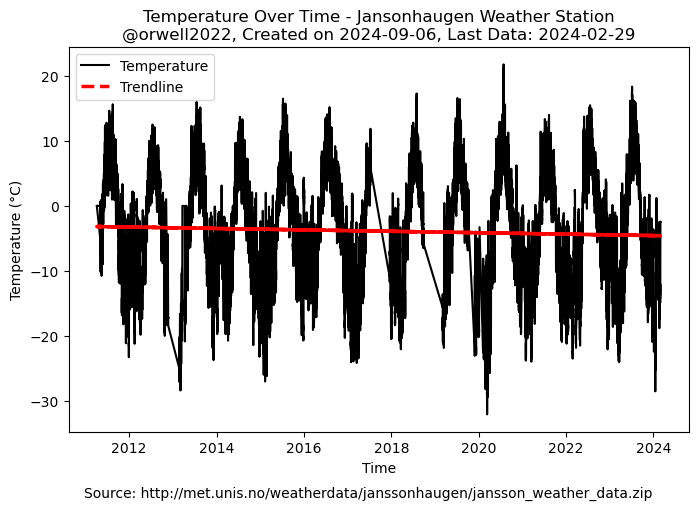

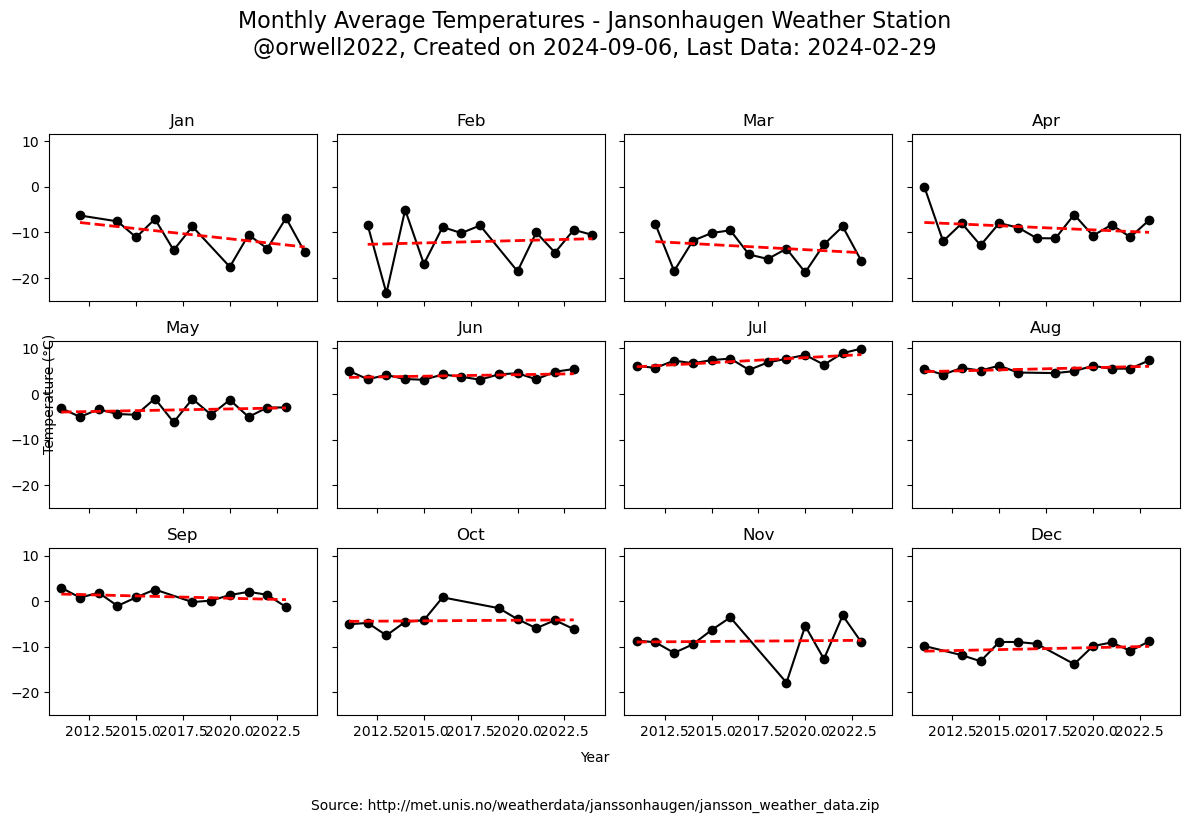

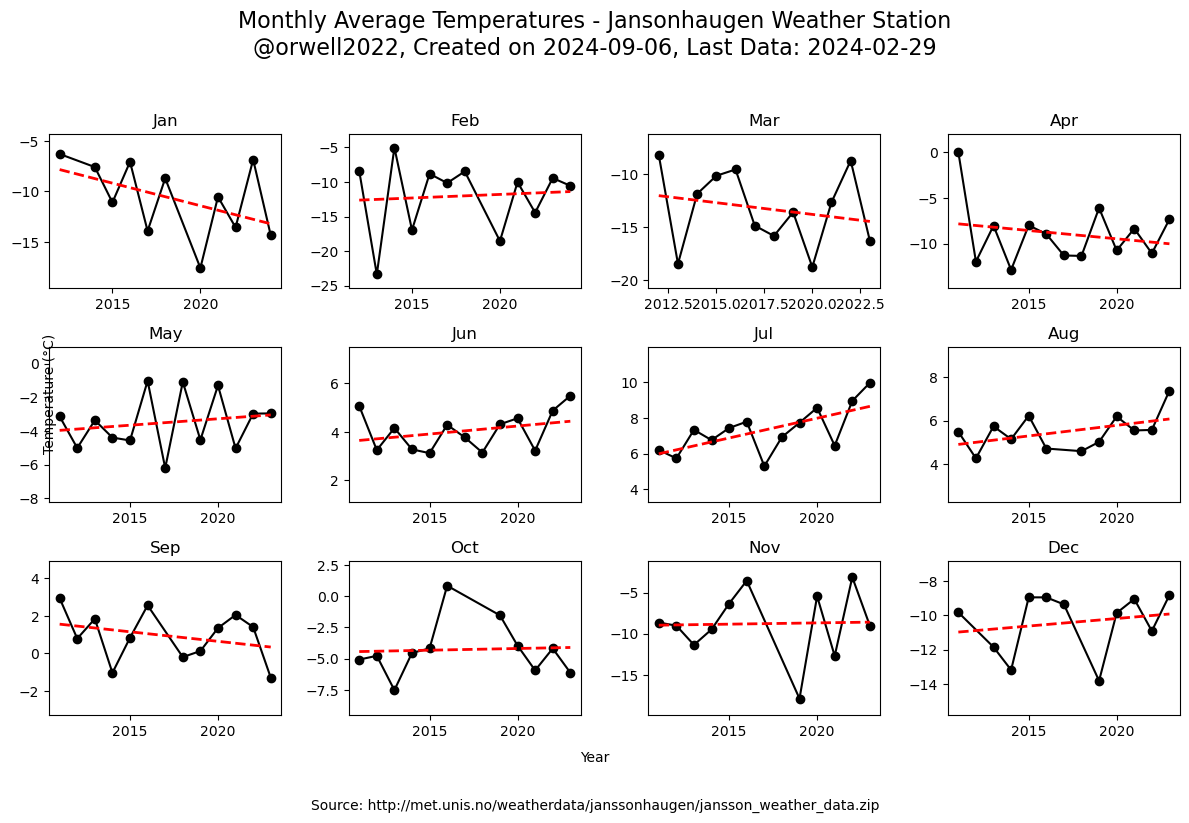

Text(0.5, 0, 'Year')

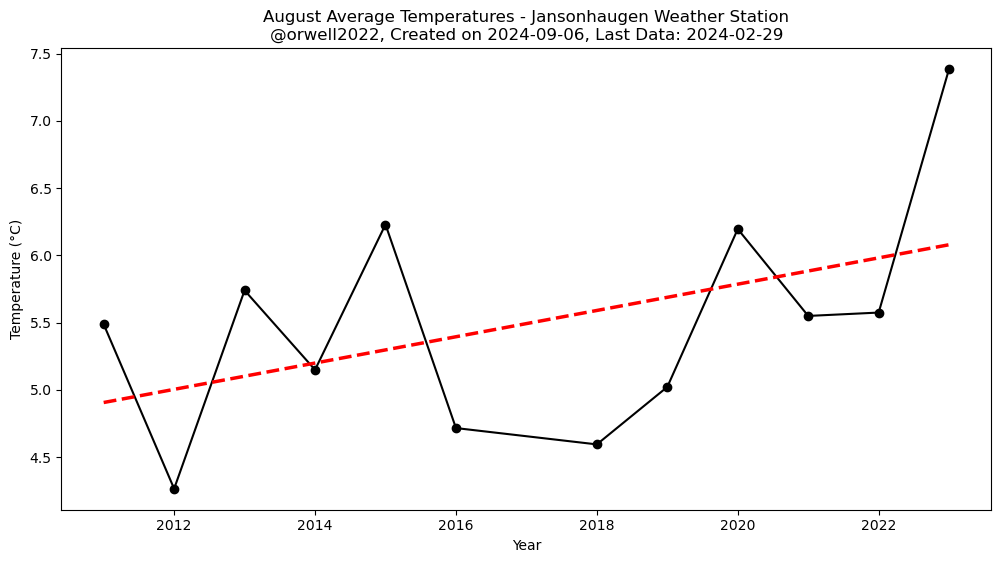

In [60]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, zipfile, io, shutil

# Delete the download directory
def clean_up(directory):
    """
    Deletes the specified directory and all its contents.
    """
    if os.path.exists(directory):
        shutil.rmtree(directory)
        print(f"Directory {directory} has been deleted.")

def download_and_extract(url, extract_to="weather_data"):
    """
    Downloads and extracts a ZIP file from the given URL.
    """
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_to)
    return extract_to

def find_dat_file(directory):
    """
    Finds the first .dat file in the given directory.
    """
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".dat"):
                return os.path.join(root, file)
    raise FileNotFoundError("No .dat file found in the directory.")

# Example usage with different URLs
# url = "http://met.unis.no/weatherdata/adventdalen/adventdalen_weather_data_hour.zip"
url = "http://met.unis.no/weatherdata/janssonhaugen/jansson_weather_data.zip"

# Step 1: Download and unzip the data
clean_up("weather_data")  # Clean up previous data if it exists
data_directory = download_and_extract(url)

# Find the .dat file in the extracted directory
dat_file_path = find_dat_file(data_directory)
print(dat_file_path)

# Extract the station name from the .dat file name
station_name = os.path.basename(dat_file_path).split('_')[0].capitalize()
print(station_name)

# Step 2: Load the data
data = pd.read_csv(dat_file_path, delimiter=',', skiprows=4)

# Step 3: Define dynamic columns based on the actual data
default_columns = [
    'TIMESTAMP', 'RECORD', 'ID', 'LT1_gr_C_Max', 'LT1_gr_C_Min', 'LT1_gr_C_Avg',
    'LT2_gr_C_Max', 'LT2_gr_C_Min', 'LT2_gr_C_Avg', 'LT3_gr_C_Max', 'LT3_gr_C_Min',
    'LT3_gr_C_Avg', 'RH_Max', 'RH_Min', 'RH_Avg', 'WS_Max', 'WS_Min', 'WS_Avg',
    'WD_Max', 'WD_Min', 'Pressure', 'Rain_Total', 'Rain_Incremental', 'SR_Max', 
    'SR_Avg', 'WindChill_Max', 'WindChill_Min', 'WindChill_Avg', 'Battery_Voltage'
]

# Adjust columns dynamically to match the data file
num_columns = len(data.columns)
if num_columns < len(default_columns):
    columns = default_columns[:num_columns]
else:
    columns = default_columns + [f"Extra_{i}" for i in range(num_columns - len(default_columns))]

data.columns = columns[:num_columns]

# Convert the TIMESTAMP column to datetime
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Create additional columns for year and month
data['Year'] = data['TIMESTAMP'].dt.year
data['Month'] = data['TIMESTAMP'].dt.month
data['Day'] = data['TIMESTAMP'].dt.day

# Step 4: Plot 1 - Overall data with a trendline, ensuring the start and end dates align

# Determine the last date in the dataset
last_date = data['TIMESTAMP'].max()

# Find the closest date in the first year that matches the last date's month and day
first_year_data = data[data['Year'] == data['Year'].min()]
try:
    first_date = first_year_data[
        (first_year_data['Month'] == last_date.month) &
        (first_year_data['Day'] == last_date.day)
    ]['TIMESTAMP'].iloc[0]
except IndexError:
    # If the exact month/day is not available, just use the earliest available date in the first year
    first_date = first_year_data['TIMESTAMP'].min()

# Filter the data to match this date range
filtered_data = data[(data['TIMESTAMP'] >= first_date) & (data['TIMESTAMP'] <= last_date)]

plt.figure(figsize=(8, 5))
plt.plot(filtered_data['TIMESTAMP'], filtered_data['LT1_gr_C_Avg'], label='Temperature', color='black')

# Calculate and plot the trendline for overall data
z_overall = np.polyfit(pd.to_numeric(filtered_data['TIMESTAMP']), filtered_data['LT1_gr_C_Avg'], 1)
p_overall = np.poly1d(z_overall)
plt.plot(filtered_data['TIMESTAMP'], p_overall(pd.to_numeric(filtered_data['TIMESTAMP'])), "r--", linewidth=2.5, label='Trendline')

# Adding labels and title
creation_date = pd.Timestamp.today().strftime('%Y-%m-%d')
last_data_day = last_date.strftime('%Y-%m-%d')

plt.title(f'Temperature Over Time - {station_name} Weather Station\n@orwell2022, Created on {creation_date}, Last Data: {last_data_day}')
plt.ylabel('Temperature (°C)')
plt.xlabel('Time')

# Adding source as footnote
plt.figtext(0.5, -0.02, f'Source: {url}', wrap=True, horizontalalignment='center', fontsize=10)

# Displaying the plot
plt.legend()
plt.show()

# (Remaining code for other plots)

# Step 5: Plot 2 - 3x4 grid of monthly average temperatures with uniform range

monthly_avg = data.groupby(['Year', 'Month'])['LT1_gr_C_Avg'].mean().reset_index()
monthly_avg_pivot = monthly_avg.pivot(index='Year', columns='Month', values='LT1_gr_C_Avg')
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, axes = plt.subplots(3, 4, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for month in range(1, 13):
    month_data = monthly_avg_pivot[month].dropna()
    ax = axes[month-1]
    ax.plot(month_data.index, month_data, linestyle='-', marker='o', color='black', label=month_labels[month-1])

    # Calculate and plot the trendline for each month
    z_month = np.polyfit(month_data.index, month_data, 1)
    p_month = np.poly1d(z_month)
    ax.plot(month_data.index, p_month(month_data.index), linestyle='--', linewidth=2, color='red')

    # Add the month label
    ax.set_title(month_labels[month-1])

fig.suptitle(f'Monthly Average Temperatures - {station_name} Weather Station\n@orwell2022, Created on {creation_date}, Last Data: {last_data_day}', fontsize=16)
fig.text(0.5, 0.04, 'Year', ha='center')
fig.text(0.04, 0.5, 'Temperature (°C)', va='center', rotation='vertical')
fig.text(0.5, -0.02, f'Source: {url}', ha='center', fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Step 6: Plot 3 - 3x4 grid of monthly average temperatures with individual maximized ranges

fig, axes = plt.subplots(3, 4, figsize=(12, 8), sharex=False, sharey=False)
axes = axes.flatten()

for month in range(1, 13):
    month_data = monthly_avg_pivot[month].dropna()
    ax = axes[month-1]
    ax.plot(month_data.index, month_data, linestyle='-', marker='o', color='black', label=month_labels[month-1])

    # Calculate and plot the trendline for each month
    z_month = np.polyfit(month_data.index, month_data, 1)
    p_month = np.poly1d(z_month)
    ax.plot(month_data.index, p_month(month_data.index), linestyle='--', linewidth=2, color='red')

    # Add the month label and maximize y-axis range individually
    ax.set_title(month_labels[month-1])
    ax.set_ylim(month_data.min() - 2, month_data.max() + 2)

fig.suptitle(f'Monthly Average Temperatures - {station_name} Weather Station\n@orwell2022, Created on {creation_date}, Last Data: {last_data_day}', fontsize=16)
fig.text(0.5, 0.04, 'Year', ha='center')
fig.text(0.04, 0.5, 'Temperature (°C)', va='center', rotation='vertical')
fig.text(0.5, -0.02, f'Source: {url}', ha='center', fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Step 7: Plot 4 - August-only plot with trendline

august_data = data[data['Month'] == 8]
august_avg = august_data.groupby('Year')['LT1_gr_C_Avg'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(august_avg['Year'], august_avg['LT1_gr_C_Avg'], linestyle='-', marker='o', color='black', label='August Avg Temperature')

# Calculate and plot the trendline
z_august = np.polyfit(august_avg['Year'], august_avg['LT1_gr_C_Avg'], 1)
p_august = np.poly1d(z_august)
plt.plot(august_avg['Year'], p_august(august_avg['Year']), "r--", linewidth=2.5, label='Trendline')

# Set the y-axis range to highlight the trend

# Adding labels and title
plt.title(f'August Average Temperatures - {station_name} Weather Station\n@orwell2022, Created on {creation_date}, Last Data: {last_data_day}')
plt.ylabel('Temperature (°C)')
plt.xlabel('Year')

#

Directory weather_data has been deleted.
weather_data\Jansonhaugen_Res_data.dat
Jansonhaugen


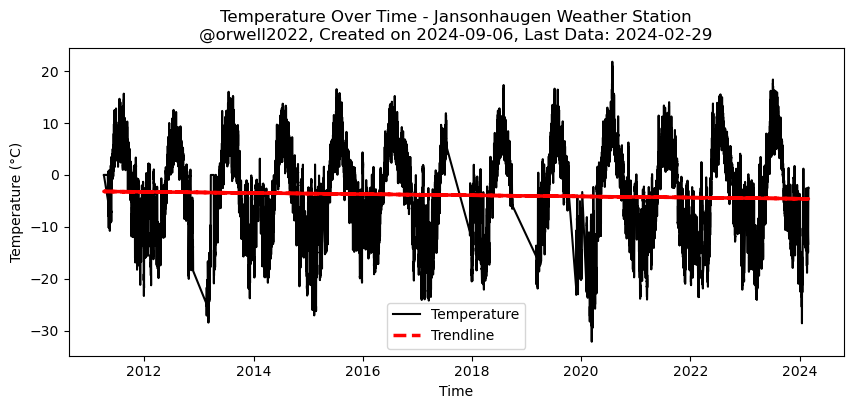

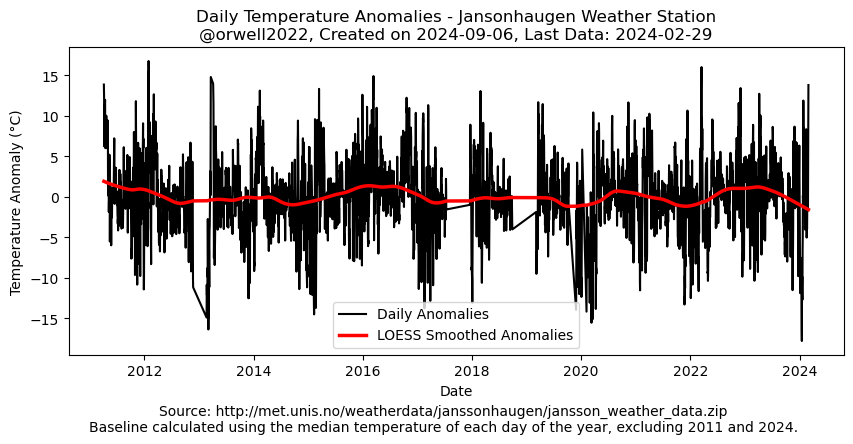

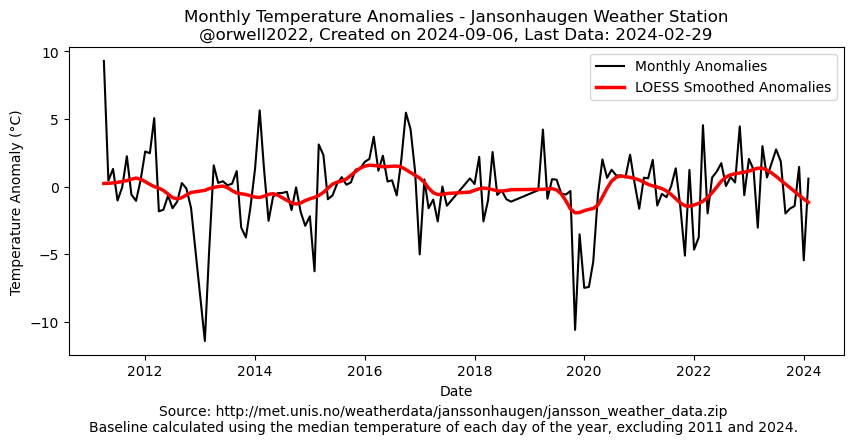

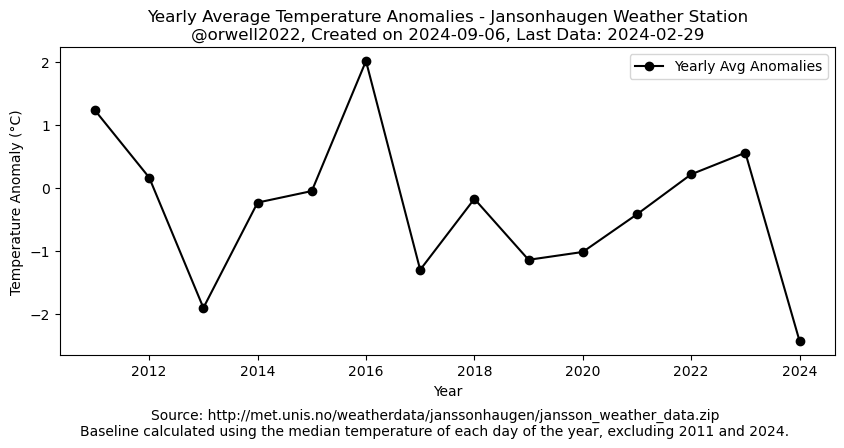

In [70]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, zipfile, io, shutil
from scipy.interpolate import interp1d
import statsmodels.api as sm

# Delete the download directory
def clean_up(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
        print(f"Directory {directory} has been deleted.")

def download_and_extract(url, extract_to="weather_data"):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_to)
    return extract_to

def find_dat_file(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".dat"):
                return os.path.join(root, file)
    raise FileNotFoundError("No .dat file found in the directory.")

# Example usage with different URLs
url = "http://met.unis.no/weatherdata/janssonhaugen/jansson_weather_data.zip"

# Step 1: Download and unzip the data
clean_up("weather_data")  # Clean up previous data if it exists
data_directory = download_and_extract(url)

# Find the .dat file in the extracted directory
dat_file_path = find_dat_file(data_directory)
print(dat_file_path)

# Extract the station name from the .dat file name
station_name = os.path.basename(dat_file_path).split('_')[0].capitalize()
print(station_name)

# Step 2: Load the data
data = pd.read_csv(dat_file_path, delimiter=',', skiprows=4)

# Step 3: Define dynamic columns based on the actual data
default_columns = [
    'TIMESTAMP', 'RECORD', 'ID', 'LT1_gr_C_Max', 'LT1_gr_C_Min', 'LT1_gr_C_Avg',
    'LT2_gr_C_Max', 'LT2_gr_C_Min', 'LT2_gr_C_Avg', 'LT3_gr_C_Max', 'LT3_gr_C_Min',
    'LT3_gr_C_Avg', 'RH_Max', 'RH_Min', 'RH_Avg', 'WS_Max', 'WS_Min', 'WS_Avg',
    'WD_Max', 'WD_Min', 'Pressure', 'Rain_Total', 'Rain_Incremental', 'SR_Max', 
    'SR_Avg', 'WindChill_Max', 'WindChill_Min', 'WindChill_Avg', 'Battery_Voltage'
]

# Adjust columns dynamically to match the data file
num_columns = len(data.columns)
if num_columns < len(default_columns):
    columns = default_columns[:num_columns]
else:
    columns = default_columns + [f"Extra_{i}" for i in range(num_columns - len(default_columns))]

data.columns = columns[:num_columns]

# Convert the TIMESTAMP column to datetime
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Create additional columns for year and month
data['Year'] = data['TIMESTAMP'].dt.year
data['Month'] = data['TIMESTAMP'].dt.month
data['Day'] = data['TIMESTAMP'].dt.day

# Step 4: Plot 1 - Overall data with a trendline, ensuring the start and end dates align

# Determine the last date in the dataset
last_date = data['TIMESTAMP'].max()

# Find the closest date in the first year that matches the last date's month and day
first_year_data = data[data['Year'] == data['Year'].min()]
try:
    first_date = first_year_data[
        (first_year_data['Month'] == last_date.month) &
        (first_year_data['Day'] == last_date.day)
    ]['TIMESTAMP'].iloc[0]
except IndexError:
    # If the exact month/day is not available, just use the earliest available date in the first year
    first_date = first_year_data['TIMESTAMP'].min()

# Filter the data to match this date range
filtered_data = data[(data['TIMESTAMP'] >= first_date) & (data['TIMESTAMP'] <= last_date)]

plt.figure(figsize=(10, 4))
plt.plot(filtered_data['TIMESTAMP'], filtered_data['LT1_gr_C_Avg'], label='Temperature', color='black')

# Calculate and plot the trendline for overall data
z_overall = np.polyfit(pd.to_numeric(filtered_data['TIMESTAMP']), filtered_data['LT1_gr_C_Avg'], 1)
p_overall = np.poly1d(z_overall)
plt.plot(filtered_data['TIMESTAMP'], p_overall(pd.to_numeric(filtered_data['TIMESTAMP'])), "r--", linewidth=2.5, label='Trendline')

# Adding labels and title
creation_date = pd.Timestamp.today().strftime('%Y-%m-%d')
last_data_day = last_date.strftime('%Y-%m-%d')

plt.title(f'Temperature Over Time - {station_name} Weather Station\n@orwell2022, Created on {creation_date}, Last Data: {last_data_day}')
plt.ylabel('Temperature (°C)')
plt.xlabel('Time')

# Adding source as footnote
#plt.figtext(0.5, -0.02, f'Source: {url}', wrap=True, horizontalalignment='center', fontsize=10)

# Displaying the plot
plt.legend()
plt.show()

# Step 8: Calculate anomalies and plot

# Group the data by day to get daily average temperature
daily_avg = data.groupby(data['TIMESTAMP'].dt.date)['LT1_gr_C_Avg'].mean().reset_index()
daily_avg.columns = ['Date', 'Daily_Avg_Temp']

# Calculate the Day of Year
daily_avg['DayOfYear'] = pd.to_datetime(daily_avg['Date']).dt.dayofyear
daily_avg['Year'] = pd.to_datetime(daily_avg['Date']).dt.year

# Exclude the first and last years from the baseline calculation
first_year = daily_avg['Year'].min()
last_year = daily_avg['Year'].max()
baseline_data = daily_avg[(daily_avg['Year'] > first_year) & (daily_avg['Year'] < last_year)]

# Calculate the median temperature for each day of the year (e.g., Jan 1, Jan 2, ...) from baseline data
median_temp_by_day = baseline_data.groupby('DayOfYear')['Daily_Avg_Temp'].median()

# Merge the daily averages with the median temperatures to calculate anomalies for the full dataset
daily_avg['Median_Temp'] = daily_avg['DayOfYear'].map(median_temp_by_day)
daily_avg['Anomaly'] = daily_avg['Daily_Avg_Temp'] - daily_avg['Median_Temp']

# Plot the anomalies for the full dataset
plt.figure(figsize=(10, 4))
plt.plot(daily_avg['Date'], daily_avg['Anomaly'], color='black', label='Daily Anomalies')

# Apply LOESS smoothing to the anomalies
smoothed_anomalies = sm.nonparametric.lowess(daily_avg['Anomaly'], np.arange(len(daily_avg)), frac=0.1)
plt.plot(daily_avg['Date'], smoothed_anomalies[:, 1], color='red', label='LOESS Smoothed Anomalies', linewidth=2.5)

# Add labels and title
plt.title(f'Daily Temperature Anomalies - {station_name} Weather Station\n@orwell2022, Created on {creation_date}, Last Data: {last_data_day}')
plt.ylabel('Temperature Anomaly (°C)')
plt.xlabel('Date')

# Adding source and baseline comment as footnote
plt.figtext(0.5, -0.04, f'Source: {url}', wrap=True, horizontalalignment='center', fontsize=10)
plt.figtext(0.5, -0.08, f'Baseline calculated using the median temperature of each day of the year, excluding {first_year} and {last_year}.', 
            wrap=True, horizontalalignment='center', fontsize=10)

# Displaying the plot
plt.legend()
plt.show()

# Step 9: Calculate monthly anomalies and plot

# Group the data by day to get daily average temperature
daily_avg = data.groupby(data['TIMESTAMP'].dt.date)['LT1_gr_C_Avg'].mean().reset_index()
daily_avg.columns = ['Date', 'Daily_Avg_Temp']

# Calculate the Day of Year
daily_avg['DayOfYear'] = pd.to_datetime(daily_avg['Date']).dt.dayofyear
daily_avg['Year'] = pd.to_datetime(daily_avg['Date']).dt.year
daily_avg['Month'] = pd.to_datetime(daily_avg['Date']).dt.month

# Exclude the first and last years from the baseline calculation
first_year = daily_avg['Year'].min()
last_year = daily_avg['Year'].max()
baseline_data = daily_avg[(daily_avg['Year'] > first_year) & (daily_avg['Year'] < last_year)]

# Calculate the median temperature for each day of the year (e.g., Jan 1, Jan 2, ...) from baseline data
median_temp_by_day = baseline_data.groupby('DayOfYear')['Daily_Avg_Temp'].median()

# Merge the daily averages with the median temperatures to calculate anomalies for the full dataset
daily_avg['Median_Temp'] = daily_avg['DayOfYear'].map(median_temp_by_day)
daily_avg['Anomaly'] = daily_avg['Daily_Avg_Temp'] - daily_avg['Median_Temp']

# Now group the anomalies by Year and Month to get monthly average anomalies
daily_avg['YearMonth'] = pd.to_datetime(daily_avg['Date']).dt.to_period('M')
monthly_anomalies = daily_avg.groupby('YearMonth')['Anomaly'].mean().reset_index()

# Plot the monthly anomalies
plt.figure(figsize=(10, 4))
plt.plot(monthly_anomalies['YearMonth'].dt.to_timestamp(), monthly_anomalies['Anomaly'], color='black', label='Monthly Anomalies')

# Apply LOESS smoothing to the anomalies
smoothed_anomalies = sm.nonparametric.lowess(monthly_anomalies['Anomaly'], np.arange(len(monthly_anomalies)), frac=0.1)
plt.plot(monthly_anomalies['YearMonth'].dt.to_timestamp(), smoothed_anomalies[:, 1], color='red', label='LOESS Smoothed Anomalies', linewidth=2.5)

# Add labels and title
plt.title(f'Monthly Temperature Anomalies - {station_name} Weather Station\n@orwell2022, Created on {creation_date}, Last Data: {last_data_day}')
plt.ylabel('Temperature Anomaly (°C)')
plt.xlabel('Date')

# Adding source and baseline comment as footnote
plt.figtext(0.5, -0.04, f'Source: {url}', wrap=True, horizontalalignment='center', fontsize=10)
plt.figtext(0.5, -0.08, f'Baseline calculated using the median temperature of each day of the year, excluding {first_year} and {last_year}.', 
            wrap=True, horizontalalignment='center', fontsize=10)

# Displaying the plot
plt.legend()
plt.show()


## Step 10: Aggregate monthly anomalies into yearly averages

# Extract the year for final aggregation from the monthly anomalies
monthly_anomalies['Year'] = monthly_anomalies['YearMonth'].dt.year

# Group by year and calculate the mean anomaly for each year
yearly_anomalies = monthly_anomalies.groupby('Year')['Anomaly'].mean().reset_index()

# Plot yearly average anomalies
plt.figure(figsize=(10, 4))
plt.plot(yearly_anomalies['Year'], yearly_anomalies['Anomaly'], linestyle='-', marker='o', color='black', label='Yearly Avg Anomalies')

# Add labels and title
plt.title(f'Yearly Average Temperature Anomalies - {station_name} Weather Station\n@orwell2022, Created on {creation_date}, Last Data: {last_data_day}')
plt.ylabel('Temperature Anomaly (°C)')
plt.xlabel('Year')

# Adding source and baseline comment as footnote
plt.figtext(0.5, -0.05, f'Source: {url}', wrap=True, horizontalalignment='center', fontsize=10)
plt.figtext(0.5, -0.09, f'Baseline calculated using the median temperature of each day of the year, excluding {first_year} and {last_year}.', 
            wrap=True, horizontalalignment='center', fontsize=10)

# Display the plot
plt.legend()
plt.show()



